In [1]:
import matplotlib.pyplot as plt

# `DotDistortionsDataset` Tutorial

*developed as part of "Revisitng Prototype Theory Through Deep Learning" (Sohn, 2022)*

## Introduction

This jupyter notebook is an interactive guide to using `DotDistortionsDataset` for research.
This dataset closely follows the visual search task proposed by Smith et al. (2005) [^1], but is designed to be used in a deep learning context. The original code is supposedly in Turbo Pascal (gasp).


[^1]: Smith, J. David; Redford, Joshua S.; Gent, Lauren C.; Washburn, David A.  (2005). Visual Search and the Collapse of Categorization. Journal of Experimental Psychology: General, 134(4), 443–460. doi:10.1037/0096-3445.134.4.443

## Minimal Example

Let's create 16 examples of a single category, with a small amount of distortion.

In [2]:
from DotDistortionsDataset import DotDistortions 

dataset = DotDistortions(
    length = 16,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [8], # pick a favorite number
    num_categories = 1,
)

Since we're starting from scratch, we must call `produce()` on the dataset. This will create the dataset according to the parameters we set above, and save it so that we can load it later.

In [3]:
dataset.produce('temp/mini_dataset.pkl')

In [4]:
dataloader = iter(dataset) # iter() turns a dataset into an iterator, which allows us to fetch consecutive data points using next()

image, bboxes, labels = next(dataloader)

The first image in this dataset:

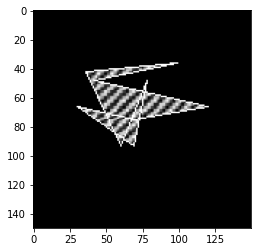

In [5]:
plt.imshow(image, cmap='gray')

Bounding box defines the outermost points on the shape:

In [6]:
bboxes

(30, 36, 120, 93)

Label refers to the category. This number is used to seed random number generator, meaning that the same number will always generate the same basic (unperturbed) shape.

In [7]:
labels

8

Let's see the whole dataset:

In [8]:
# just a little function to show images in a grid
def show_bunch(
    dataset,
    rows = 2,
    x_figsize=20,
    y_figsize=5,):
    dataset.produce()
    dataloader=iter(dataset)
    fig = plt.figure(figsize=(x_figsize,y_figsize))
    for i in range(len(dataset)):
        image, bboxes, labels = next(dataloader)
        ax = fig.add_subplot(rows, len(dataset)//rows, i+1)
        ax.set_title(str(labels))
        # no ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image, cmap='gray')

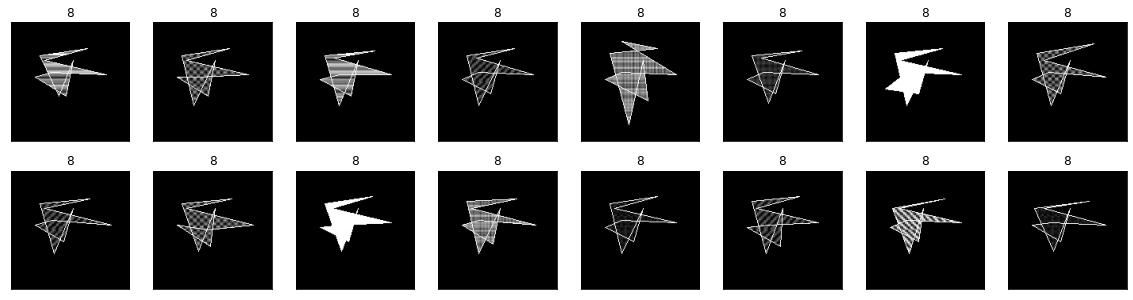

In [9]:
dataset = DotDistortions(
    length = 16,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [8], # pick a favorite number
    num_categories = 1,
)

show_bunch(dataset)

## Playing with Dataset Parameters

### Distortion Level

Notice how the above shapes are all quite similar to each other. It would be pretty easy to learn these shapes from the images.

**What happens if we increase the distortion level?**

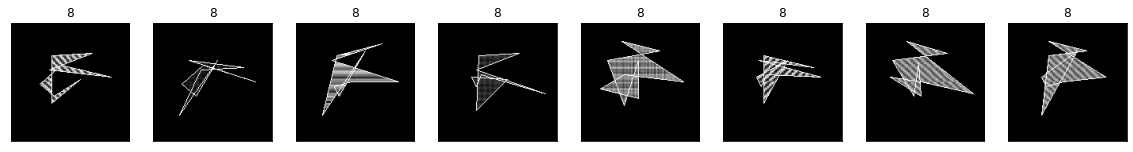

In [10]:
dataset = DotDistortions(
    length = 8,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [8], # pick a favorite number
    num_categories = 1,
    distortion_level = '7.7' # MAXIMUM distortion!
)

show_bunch(dataset, rows=1, x_figsize=20, y_figsize=2.5)

With a high distortion level of '7.7', it becomes harder to see the commonality between the shapes.

Choose from: `'1','2','3','4,'5','6,'7.7'`.

### Categories

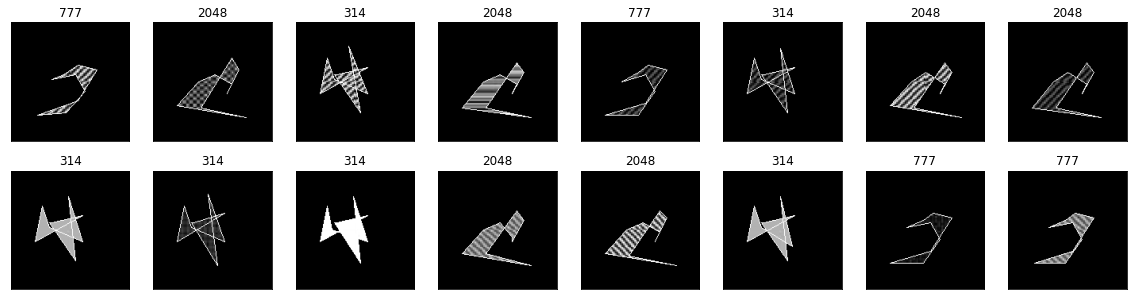

In [11]:
dataset = DotDistortions(
    length = 16,
    train_like = True,
    category_seeds = [2**11, 314, 777], # pick three favorite numbers
    num_categories = 3, # match the number of categories
    distortion_level = '1' # no distortion
)

show_bunch(dataset, rows=2, x_figsize=20, y_figsize=5)

Supplying the same number into `category_seeds` will always generate the same basic shapes. The order and shading type will always be random.

### Test-like Mode

In the reference literature, subjects were trained to identify single-shape images (shown above). Then, they were shown an image containing 7 mixed shapes containing 0 or 1 shape from the trained categories. Participants were asked to select wheter they saw a trained shape in the test image.

For example, let's say that one of the shapes we were trained to identify was:

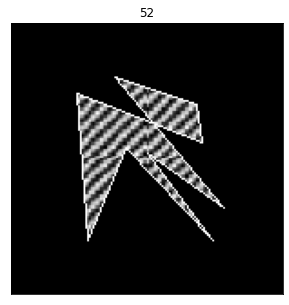

In [12]:
dataset = DotDistortions(
    length = 1,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [52], # pick a favorite number
    num_categories = 1,
)

show_bunch(dataset, rows=1, x_figsize=5, y_figsize=5)

Do you see this shape in each of the test images below?

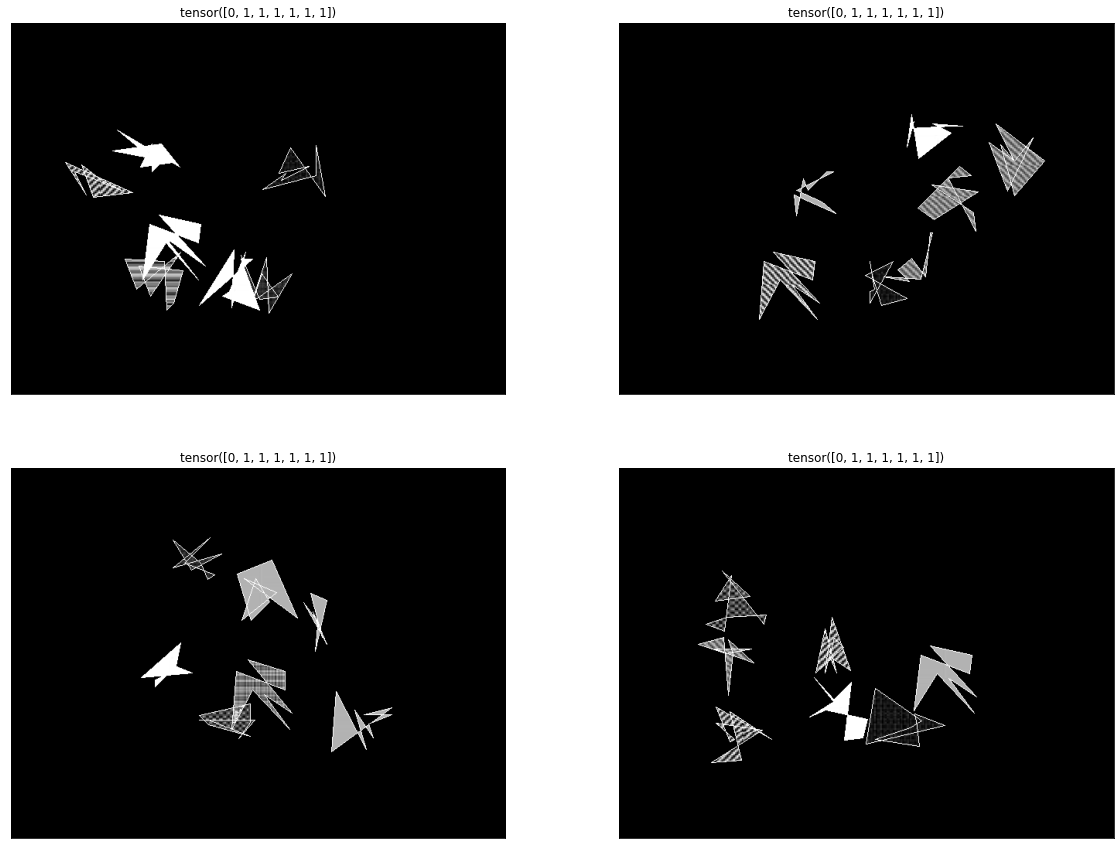

In [13]:
dataset = DotDistortions(
    length = 4,
    train_like = False, # test mode
    category_seeds = [52], 
    num_categories = 1,
    distortion_level = '1', # no distortion; easy mode
    test_like_exists_probability=1.0, # test image will certainly contain a shape of trained category
    total_shapes = 7, # total number of shapes in test image
)

show_bunch(dataset, rows=2, x_figsize=20, y_figsize=15)

The answer is YES! 

Note: The category numbers of random (non-trained) shapes are all '-1'.

Here are some more examples of test images, but now some do not contain the shape we were trained to identify.

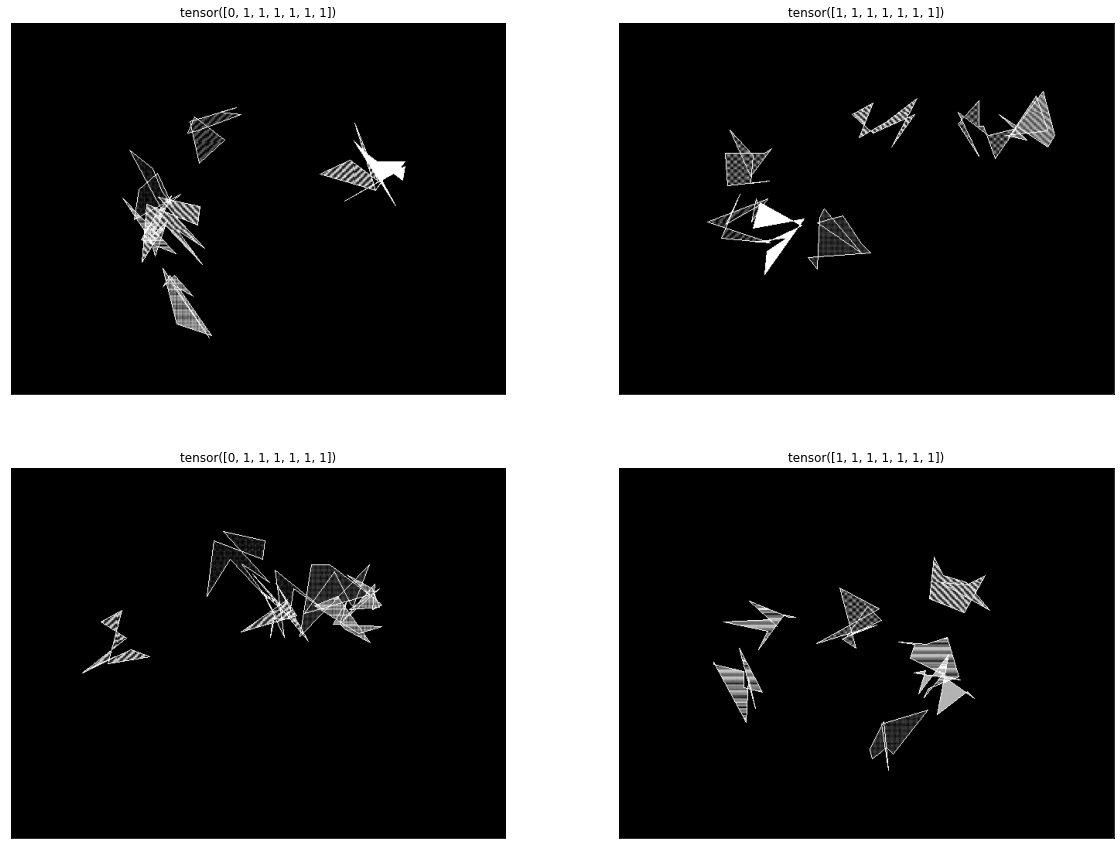

In [14]:
dataset = DotDistortions(
    length = 4,
    train_like = False, # test mode
    category_seeds = [52], 
    num_categories = 1,
    distortion_level = '1', # no distortion; easy mode
    test_like_exists_probability=0.25, # a quarter of the test images will contain a shape of trained category
    total_shapes = 7, # total number of shapes in test image
)

show_bunch(dataset, rows=2, x_figsize=20, y_figsize=15)

To check your guesses, an all-'-1' title means no shapes of the trained categories exist in that test image.

## Conversion to PyTorch Tensor

When using the dataset with PyTorch for deep learning, we need to convert the outputs of our dataset into tensors.
I have made that as easy as setting `torch_transform = True`.

In [15]:
dataset = DotDistortions(
    length = 16,
    train_like = True,
    category_seeds = [37,65,129],
    num_categories = 3, 
    torch_transform = True, # convert output to torch tensors
)

dataset.produce()
image, bboxes, labels = next(iter(dataset)) # get the first image and related data

Just to confirm:

In [16]:
print(type(image))
print(image.shape)

<class 'torch.Tensor'>
torch.Size([150, 150])


In [17]:
print(type(bboxes))
print(bboxes)

<class 'torch.Tensor'>
tensor([ 36,  33, 108, 117])


Labels are turned into zero-indexed integers. (That's just the way PyTorch likes it)

That is, our category seeds [37, 65, 129] will be turned into [0, 1, 2]. You as the researcher should keep track of this relation.

In [18]:
print(type(labels))
print(labels)

<class 'torch.Tensor'>
tensor([0])


## Saving and Loading Dataset

If you are using this tool in seriousness, you should be keeping track of the parameters you set.

However, even with the exact same parameters, some features of the dataset will change between instantiations. (e.g. shading pattern type, location of shapes on test image).

Therefore, if you want perfect reproducibility, you should save the dataset.

The dataset was already automatically saved when you called `produce()` at the beginning (see 'temp' directory), but if you want to save the dataset yourself, you can do so by calling `save(new_dataset_name.pkl)`.




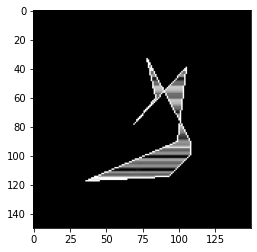

In [19]:
plt.imshow(image, cmap='gray')

In [20]:
dataset.save('temp/demo_dataset.pkl')

Then, when you're ready to work on that same dataset, create an empty dataset, and load the saved dataset pickle file:

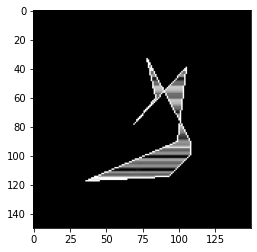

In [21]:
dataset = DotDistortions()
dataset.load('temp/demo_dataset.pkl')

image, bboxes, labels = next(iter(dataset)) # let's see if we loaded it properly

plt.imshow(image, cmap='gray') # should be the same image as above

# Feeding into Neural Network

All of the above was just a prelude to this main part.

For this demonstration, we will use two different neural networks for the training and test conditions.

Fusing the two neural networks (weight sharing) is a slightly more advanced topic and will be covered in another notebook.

By now we are familiar with instantiating and generating a dataset:

In [22]:
train_dataset = DotDistortions(
    length = 16000,
    train_like = True,
    category_seeds = [2**11, 314, 777], # pick three favorite numbers
    num_categories = 3, # match the number of categories
    distortion_level = '1', # no distortion
    torch_transform=True, # convert output to torch tensors
)
train_dataset.produce()

In [23]:
test_dataset = DotDistortions(
    length = 1600,
    train_like = True,
    category_seeds = [2**11, 314, 777], # pick three favorite numbers
    num_categories = 3, # match the number of categories
    distortion_level = '1', # no distortion
    torch_transform=True, # convert output to torch tensors
)
test_dataset.produce()

Previously, we simply wrapped the dataset in `iter()` and called `next()` on the iterator. The proper PyTorch way is to use `DataLoader`.

In [24]:
batch_size = 16

In [25]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
# manual seed for reproducibility
torch.manual_seed(4)

We define a basic convolutional neural network:

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class BasicConvNet(nn.Module):
    def __init__(self, num_classes=3, dropout=0.5):

        super(BasicConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,256, kernel_size=3, padding=1)
            )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(9216, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1000, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=0)
        return x

In [28]:
class LinearNet(nn.Module):
    def __init__(self, num_classes=3, dropout=0.5):

        super(LinearNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(150*150, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        x = torch.flatten(x,1)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=0)
        return x

In [29]:
net = BasicConvNet()
#net = LinearNet()
net = net.cuda()

Then, we define the loss function and optimizer:

In [30]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        images, bboxes, labels = data
        labels = labels.flatten()
        images = images.unsqueeze(1)
        images = 2 * (images - 0.5) # [0-1] to [-1,1]
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss:.3f}")
    running_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for i,d in enumerate(testloader,0):
            images, bboxes, labels = d
            images = 2 * (images - 0.5)
            images = images.unsqueeze(1)
            labels = labels.flatten()
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            #softmax_labels = F.log_softmax(outputs, dim=1)
            preds_classes = torch.argmax(outputs, axis=-1)
            correct += int(torch.sum(preds_classes.cpu() == labels.cpu()))
            total += batch_size
        print(f"\tTest Accuracy: {100*correct/total:.3f} %")
        #plt.show(visualize_layer(net, 0))

Epoch 1, loss: 364.124
	Test Accuracy: 76.312 %
Epoch 2, loss: 8068.081
	Test Accuracy: 99.750 %
Epoch 3, loss: 583.036
	Test Accuracy: 99.938 %
Epoch 4, loss: 55.505
	Test Accuracy: 99.812 %
Epoch 5, loss: 72.642
	Test Accuracy: 99.688 %
Epoch 6, loss: 1464.357
	Test Accuracy: 99.750 %


# Experiment Diary

Using AlexNet, having difficulty getting any training- random chance. Is something wrong with the setup?

